In [1]:
import json
import urllib
import pandas as pd
import numpy as np
import requests
import json
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
texas = pd.read_csv('statement_data.csv')

In [3]:
texas.head()

,execution,offender_information,last_statement,last_name,first_name,tdcj_number,age,date,race,county,statement_text
0,538,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Fuller,Barney,999481,58,10/05/2016,White,Houston,"I don't have anything to say, you can proceed ..."
1,537,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Vasquez,Pablo,999297,38,04/06/2016,Hispanic,Hidalgo,"I just want to tell my family thank you, my mo..."
2,536,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Ward,Adam,999525,33,03/22/2016,White,Hunt,I would like to thank everyone that has showed...
3,535,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Wesbrook,Coy,999281,58,03/09/2016,White,Harris,"Yeah, first off, I want to say that I am sorry..."
4,534,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Garcia,Gustavo,999018,43,02/16/2016,Hispanic,Collin,"To my family, to my mom, I love you. God bless..."


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from altair import Chart, X, Y, Axis, Scale, Color, Bin, SortField, Column, Formula

# Two convenience functions to work with Altair and Matplotlib
def show(*charts, width=700, height=300):
    for chart in charts:
        chart.configure_cell(width=width, height=height).display()
        
def pie(ax, *args, **kwargs):
    patches, _, _ = ax.pie(
        *args,
        colors=['#BEE9E8', '#62B6CB', '#5FA8D3', '#DCEDEC'],
        autopct='%1.1f%%',
        **kwargs
    )
    for p in patches:
        p.set_linewidth(0.6)
    ax.axis('equal')

In [5]:
import scrapy

class TexasDeathSpider(scrapy.Spider):
    name = 'texas_death'
    allowed_domains = ['www.tdcj.state.tx.us']
    start_urls = (
        'http://www.tdcj.state.tx.us/death_row/dr_executed_offenders.html',
    )

    def parse(self, response):
        _, *rows = response.css('table tr')
        fields = ['execution', 'last_name', 'first_name', 'tdcj_number',
                  'age_execution', 'date_execution', 'race', 'county']
        for row in rows:
            item = PersonItem()
            values = row.css('td::text').extract()
            if len(values) > len(fields):
                # Special cases: people #416 and #419
                del values[1]
            for field, value in zip(fields, values):
                item[field] = value.strip()

            info, last_stmt = row.css('td > a::attr(href)').extract()
            no_info = info.endswith(('.jpg', 'no_info_available.html'))
            no_stmt = last_stmt.endswith('no_last_statement.html')
            if no_info:
                item['gender'] = ''
                info = False
            if no_stmt:
                item['last_statement'] = ''

            if no_info and no_stmt:
                yield item
            elif no_stmt:
                yield scrapy.Request(response.urljoin(info),
                                     callback=self.parse_gender,
                                     meta={'item': item})
            else:
                info_url = response.urljoin(info) if info else False
                yield scrapy.Request(response.urljoin(last_stmt),
                                     callback=self.parse_last_stmt,
                                     meta={'item': item,
                                           'info_url': info_url})

    def parse_last_stmt(self, response):
        item = response.meta['item']
        info_url = response.meta['info_url']
        ps = [p.strip() for p in response.css('p::text').extract()
              if p.strip()]
        item['last_statement'] = ps[-1]
        if not info_url:
            yield item
            return
        yield scrapy.Request(
                info_url,
                callback=self.parse_gender,
                meta={'item': item},
        )

    def parse_gender(self, response):
        item = response.meta['item']
        rows = response.css('table tr')
        item['gender'] = rows[10].css('td::text').extract()[-1].strip()
        yield item
        
        
# dataset = tablib.Dataset()
# dataset.headers = ["reference_link", "rss_link"]

# def add_item(item):    
#    dataset.append([item.get(field) for fields in dataset.headers])

# for item in items:
#     add_item(item)

# f.write(texas_death_items.csv)  


#scrapy crawl <TexasDeathSpider> -o texas_death_items.csv -t csv
        


In [6]:
people = pd.read_csv('statement_data.csv')

In [7]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 11 columns):
execution               538 non-null int64
offender_information    538 non-null object
last_statement          538 non-null object
last_name               538 non-null object
first_name              538 non-null object
tdcj_number             538 non-null int64
age                     538 non-null int64
date                    538 non-null object
race                    538 non-null object
county                  538 non-null object
statement_text          538 non-null object
dtypes: int64(3), object(8)
memory usage: 46.3+ KB


In [8]:
people.head()

,execution,offender_information,last_statement,last_name,first_name,tdcj_number,age,date,race,county,statement_text
0,538,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Fuller,Barney,999481,58,10/05/2016,White,Houston,"I don't have anything to say, you can proceed ..."
1,537,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Vasquez,Pablo,999297,38,04/06/2016,Hispanic,Hidalgo,"I just want to tell my family thank you, my mo..."
2,536,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Ward,Adam,999525,33,03/22/2016,White,Hunt,I would like to thank everyone that has showed...
3,535,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Wesbrook,Coy,999281,58,03/09/2016,White,Harris,"Yeah, first off, I want to say that I am sorry..."
4,534,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Garcia,Gustavo,999018,43,02/16/2016,Hispanic,Collin,"To my family, to my mom, I love you. God bless..."


In [9]:
people.date.map(len).value_counts()

10    536
9       2
Name: date, dtype: int64

In [10]:
people.date[people.date.map(len) == 9]

9      10/6/2015
118    11/6/2008
Name: date, dtype: object

In [11]:
import datetime

def _read_date(date):
    return datetime.datetime.strptime(date, '%m/%d/%Y')

people.date = people.date.map(_read_date)

In [12]:
race_counts = people['race'].value_counts().reset_index()
race_counts.columns = ['race', 'count']
pop = pd.DataFrame({'race': ['White', 'Black', 'Hispanic', 'Other'], 'count': [196817552, 37685848, 50477594, 23764544]})

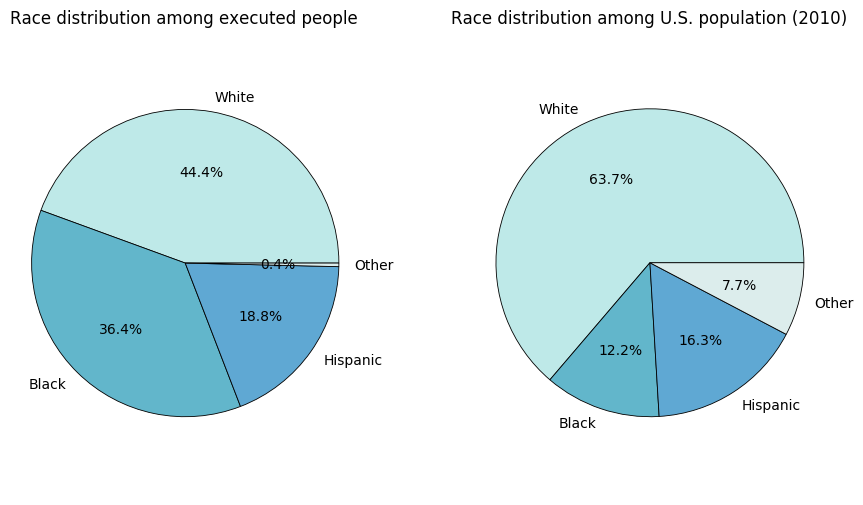

In [13]:
# #Change to different visualization--- not pie chart
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
pie(ax1, race_counts['count'], labels=race_counts['race'])
pie(ax2, pop['count'], labels=pop['race'])
ax1.set_title('Race distribution among executed people')
ax2.set_title('Race distribution among U.S. population (2010)')
fig.subplots_adjust(wspace=0.5)
plt.show(fig)




In [14]:
# show(Chart(people[['race', 'count']]).mark_bar().encode(
#         column=Column('race',
#                       bin=Bin(maxbins=10)),
#         x=X('race',
#             axis=Axis(labels=False, tickSize=0, titleFontSize=0),
#             scale=Scale(bandSize=8)),
#         y='count(*)',
#         color='race',
#     ).configure_facet_cell(strokeWidth=0))



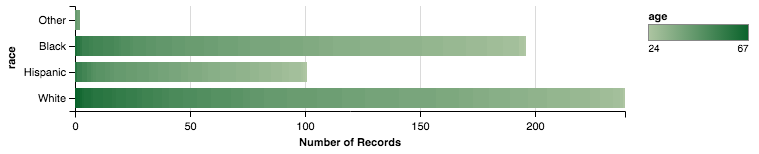

In [15]:
show(Chart(people[['race', 'age']].dropna()).mark_bar().encode(
        x='count(*)',
        y=Y('race',
            sort=SortField('count(*)', op='mean', order='descending')),
        color='age',
    ), width=550)

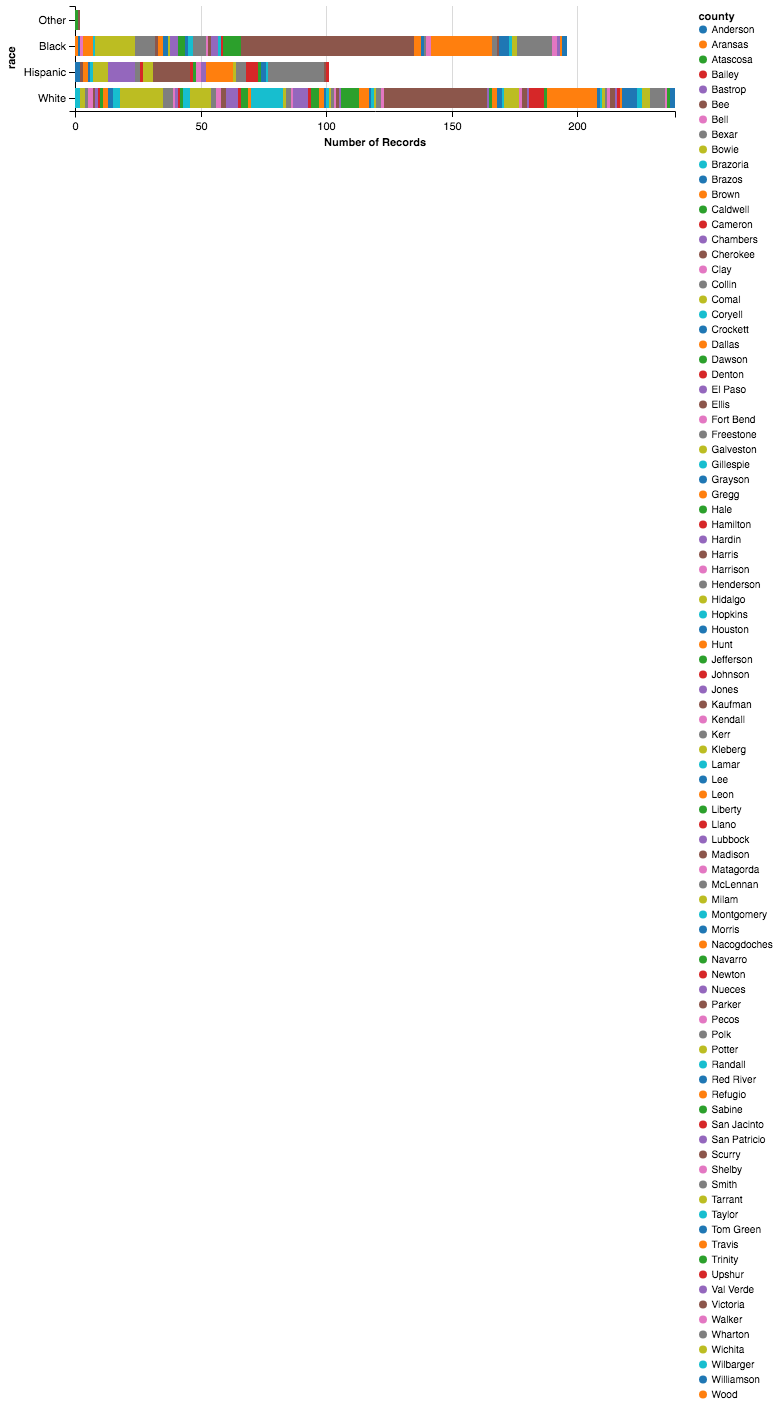

In [16]:
show(Chart(people[['race', 'county']].dropna()).mark_bar().encode(
        x='count(*)',
        y=Y('race',
            sort=SortField('count(*)', op='mean', order='descending')),
        color='county',
    ), width=600)

In [17]:
people.head(2)


,execution,offender_information,last_statement,last_name,first_name,tdcj_number,age,date,race,county,statement_text
0,538,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Fuller,Barney,999481,58,2016-10-05,White,Houston,"I don't have anything to say, you can proceed ..."
1,537,http://www.tdcj.state.tx.us/death_row/dr_info/...,http://www.tdcj.state.tx.us/death_row/dr_info/...,Vasquez,Pablo,999297,38,2016-04-06,Hispanic,Hidalgo,"I just want to tell my family thank you, my mo..."


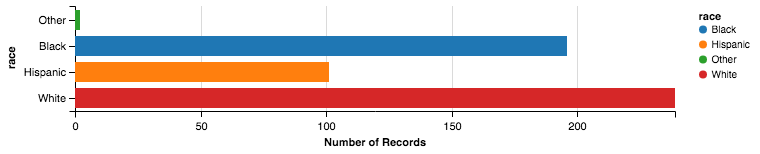

In [18]:
show(Chart(people[['race', 'age']].dropna()).mark_bar().encode(
        x='count(*)',
        y=Y('race',
            sort=SortField('count(*)', op='mean', order='descending')),
        color='race',
    ), width=600)

In [22]:
import textblob

In [23]:
statements = people.statement_text.dropna()
blobs = statements.map(lambda s: textblob.TextBlob(s))
n_sentences = blobs.map(lambda b: len(b.sentences))

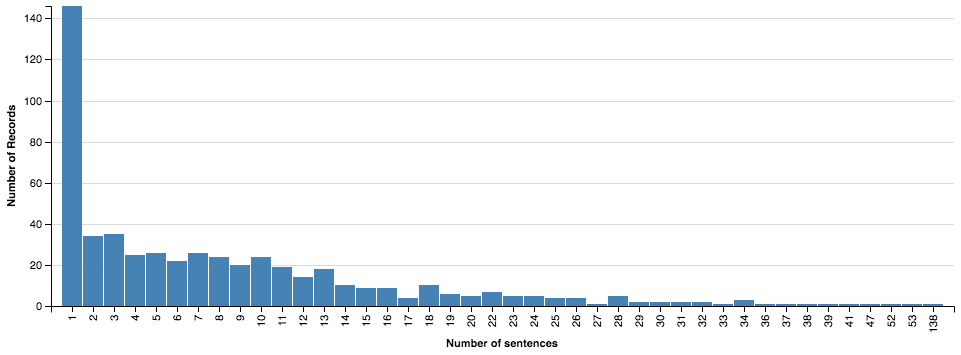

In [24]:
show(Chart(pd.DataFrame({'Number of sentences': n_sentences})).mark_bar().encode(
        x='Number of sentences:N',
        y='count(*)',
    ))

In [25]:
# The distribution of the number of sentences is skewed to the left, favoring shorter statements. There's one statement that separates itself from the rest: it is much longer than all the others, at 138 sentences. 
# Out of curiosity, let's investigate a bit:

In [26]:
len(blobs[n_sentences.argmax()].words)

1294

In [28]:
people[['last_name', 'first_name', 'race', 'date']].ix[n_sentences.argmax()]


last_name                  Graham
first_name                   Gary
race                        Black
date          2000-06-22 00:00:00
Name: 316, dtype: object

In [29]:
#Research statement and paint a picture in presentation

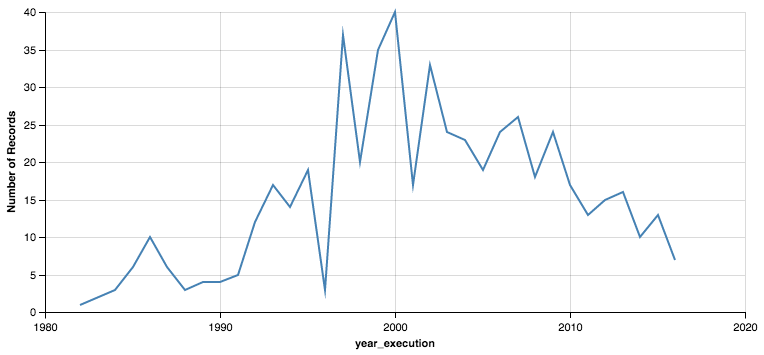

In [32]:
people['year_execution'] = people.date.map(lambda d: d.year)
show(Chart(people).mark_line().encode(
        x=X('year_execution',
            axis=Axis(format='f'),
            scale=Scale(zero=False)),
        y='count(*)',
    ))

#What context do we have for this??
#That's quite a lot: about one every 9 days. Year 2000 has been called 'A Watershed Year of Change', because numerous exonerations revealed persistent errors in the administration of capital punishment and increased public awareness. Many capital punishment advocates changed their mind and joined the growing movement that called for reforms and ultimately the abolishment of death penalty. 
#This also serves as a good explanation for the downward trend that follows year 2000.

In [33]:
import scrapy
import requests

counties = []
body = scrapy.Selector(
    text=requests.get('https://en.wikipedia.org/wiki/User:Michael_J/County_table').text
)
_, *rows = body.css('table tr')
for row in rows:
    cols = row.css('td ::text').extract()
    if cols[1] == 'TX':
        lat, long = map(lambda i: i.strip('°').replace('\u2013', '-'), cols[-2:])
        counties.append((cols[3], lat, long))
counties = pd.DataFrame(counties, columns=['county', 'lat', 'lon'])

In [34]:
counties.lat = pd.to_numeric(counties.lat)
counties.lon = pd.to_numeric(counties.lon)

In [35]:
counties.head()

,county,lat,lon
0,Anderson,31.841266,-95.661744
1,Andrews,32.312258,-102.640206
2,Angelina,31.251951,-94.611056
3,Aransas,28.104225,-96.977983
4,Archer,33.616305,-98.687267


In [36]:
county_count = people.groupby(people.county).size().reset_index(name='count')
county_count.head()

,county,count
0,Anderson,4
1,Aransas,1
2,Atascosa,1
3,Bailey,1
4,Bastrop,1


In [37]:
county_data = county_count.merge(counties, on='county')
county_data.head()

,county,count,lat,lon
0,Anderson,4,31.841266,-95.661744
1,Aransas,1,28.104225,-96.977983
2,Atascosa,1,28.894296,-98.528187
3,Bailey,1,34.067521,-102.830345
4,Bastrop,1,30.103128,-97.311859


In [47]:
import os
import gmaps

gmaps.configure(api_key="AI...")

gmaps.configure(api_key=os.environ['GMAPS_API_KEY'])

KeyError: 'GMAPS_API_KEY'

In [42]:
m = gmaps.Map()
data = county_data[['lat', 'lon', 'count']].values.tolist()
heatmap = gmaps.WeightedHeatmap(data=data, point_radius=30)
m.add_layer(heatmap)
m

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [44]:
county_count.sort_values(by='count', ascending=False).head(10)
#It's evident that violent crimes leading to death penalties peak in the largest cities. 

,county,count
35,Harris,126
21,Dallas,55
7,Bexar,42
78,Tarrant,38
64,Nueces,16
42,Jefferson,15
59,Montgomery,15
54,Lubbock,12
10,Brazos,12
77,Smith,12


In [45]:
try:
    with open('statements.txt') as fobj:
        all_text = fobj.read()
except OSError:
    to_replace = {
        '\xa0': '',
        '’': '\'',
        '‘': '\'',
        '“': '"',
        '”': '"',
        '\u2013': '-',
        '\u2026': '...',
        '(Spanish)': '',
        '(English)': '',
    }
    all_text = statements.str.cat(sep='\n')
    for a, b in to_replace.items():
        all_text = all_text.replace(a, b)
    with open('statements.txt', 'w') as fobj:
        fobj.write(all_text)

In [46]:
import wordcloud
import matplotlib.pyplot as plt
from scipy.misc import imread

colors = wordcloud.ImageColorGenerator(imread('colors.png'))
wc = wordcloud.WordCloud(background_color='white',
                         scale=2,
                         max_words=200,
                         relative_scaling=0.6)
words = wc.process_text(all_text)
wc.generate_from_frequencies(words)
plt.figure(figsize=(12, 6))
plt.imshow(wc.recolor(color_func=colors))
plt.axis('off')
plt.show()

ImportError: No module named 'wordcloud'

In [48]:
import collections

counts = collections.Counter(dict(words))
most_common = pd.DataFrame(counts.most_common(20), columns=['Word', 'Count'])
show(Chart(most_common).mark_bar().encode(
        x=X('Word',
            scale=Scale(bandSize=30),
            sort=SortField('Count')),
        y='Count',
        color=Color('Count',
                    scale=Scale(range=['orange', 'darkred']),
                    bin=Bin(maxbins=3)),
    ), height=350)

NameError: name 'words' is not defined

In [49]:
all_sentiments = blobs.map(lambda b: b.sentiment)

In [50]:
import operator

people_with_stmt = people.iloc[people.last_statement.dropna().index].copy()
people_with_stmt['sentiment_polarity'] = [s.polarity for s in all_sentiments]
people_with_stmt['sentiment_subjectivity'] = [s.subjectivity for s in all_sentiments]


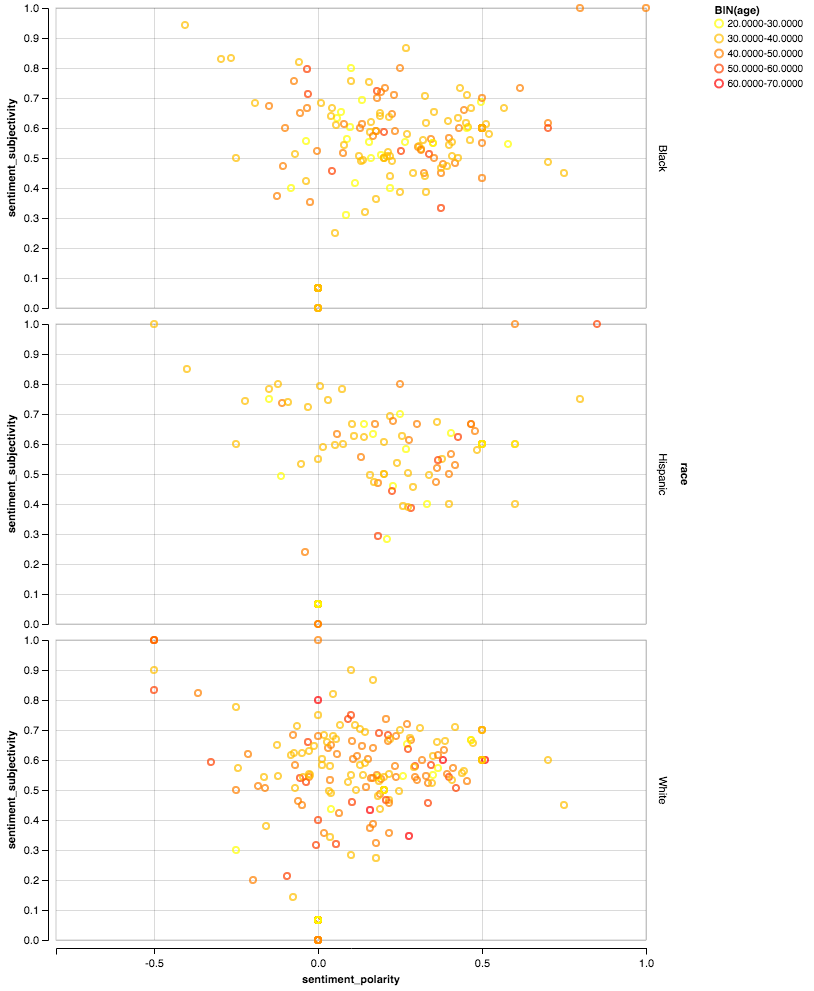

In [53]:

data = people_with_stmt[['race', 'sentiment_polarity', 'sentiment_subjectivity', 'age']]
data = data[data.race != 'Other']
show(Chart(data).mark_point().encode(
        x=X('sentiment_polarity',
            scale=Scale(range=[-1, 1])),
        y=Y('sentiment_subjectivity',
            scale=Scale(range=[0, 1])),
        color=Color('age',
                    scale=Scale(range=['yellow', 'red']),
                    bin=Bin(maxbins=5)),
        row='race',
    ), width=590)

In [54]:
people_with_stmt[['race', 'sentiment_polarity']].groupby(people_with_stmt['race']).mean()

,sentiment_polarity
race,
Black,0.192707
Hispanic,0.178677
Other,0.300000
White,0.097552


In [55]:
people_with_stmt[['race', 'sentiment_subjectivity']].groupby(people_with_stmt['race']).mean()

,sentiment_subjectivity
race,
Black,0.454842
Hispanic,0.488320
Other,0.433333
White,0.430113


In [62]:
people.columns

Index(['execution', 'offender_information', 'last_statement', 'last_name',
       'first_name', 'tdcj_number', 'age', 'date', 'race', 'county',
       'statement_text', 'year_execution'],
      dtype='object')

In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, use_idf=True)
svd = TruncatedSVD(n_components=20)
pipe = make_pipeline(
    vectorizer,
    svd,
    Normalizer(copy=False),
)

X_s = pipe.fit_transform(people_with_stmt.statement_text)

In [64]:
X_s.shape

(538, 20)

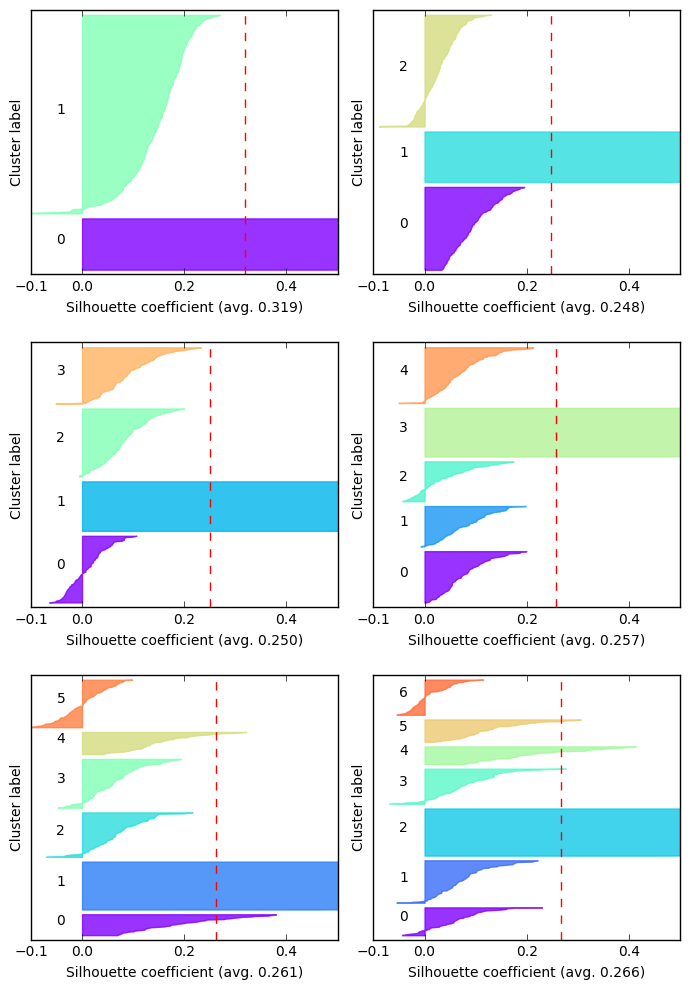

In [65]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

fig, axes = plt.subplots(3, 2, figsize=(7, 10))

for n_clusters in range(2, 8):
    ax = axes[n_clusters // 2 - 1, n_clusters & 1]
    ax.set_xlim([-0.1, 0.5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_s) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=2, max_iter=10000)
    cluster_labels = clusterer.fit_predict(X_s)

    silhouette_avg = silhouette_score(X_s, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_s, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_silhouette = sample_silhouette_values[cluster_labels == i]
        ith_silhouette.sort()

        size_cluster_i = ith_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(i / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_silhouette,
                         facecolor=color, edgecolor=color, alpha=0.8)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax.set_xlabel('Silhouette coefficient (avg. {:.3f})'.format(silhouette_avg))
    ax.set_ylabel('Cluster label')

    ax.axvline(x=silhouette_avg, color='red', linestyle='--')

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4])

fig.tight_layout(h_pad=2)
plt.show(fig)

In [68]:
###Pulling from the wrong column
def print_topics(n_clusters):
    km = KMeans(n_clusters=n_clusters, max_iter=10000)
    km.fit(X_s)
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    clusters = [[terms[ind] for ind in order_centroids[i, :8]]
                for i in range(n_clusters)]
    for i in range(n_clusters):
        print('{}) {}'.format(i, ' '.join(clusters[i])))
        
print_topics(6)
#six clusters is a better model than 3

0) declined offender statement make final ready innocent appreciate
1) love thank warden ready tell family yes like
2) say know want just don love did everybody
3) god lord jesus thank life forgive love christ
4) ll ya love tell going family know god
5) sorry family love hope pain caused like forgive


In [69]:
print_topics(3)


0) family love thank sorry like lord god peace
1) declined offender statement make final ready innocent appreciate
2) love know ll want tell ya did warden


In [75]:
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

tokens = people_with_stmt.statement_text.map(tokenize).values

In [76]:
from gensim.corpora import Dictionary

dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(t) for t in tokens]

In [77]:
from gensim.models import TfidfModel, LsiModel

tfidf_model = TfidfModel(corpus, id2word=dictionary)
lsi_model = LsiModel(tfidf_model[corpus], id2word=dictionary, num_topics=3)

In [78]:
[(label, [word[0] for word in words])
 for label, words in lsi_model.show_topics(num_words=7, formatted=False)]

[(0, ['declined', 'offender', 'statement', 'final', 'clear', 'words', 'want']),
 (1, ['love', 'll', 'sorry', 'thank', 'family', 'ya', 'know']),
 (2, ['ll', 'ya', 'peace', 'caused', 'sorry', 'thank', 'pain'])]